In [1]:
from PIL import Image, ImageFilter
from skimage.filters import frangi
from skimage.filters import threshold_otsu
import sys
sys.path.append('../')
import numpy as np
from pathlib import Path
from test import mse

def acc(a, b):
    a = (np.array(a)/255.0).astype(bool)
    b = (np.array(b)/255.0).astype(bool)
    assert(a.size == b.size)
    size = a.size
    correct = (a == b).sum()
    return correct/size * 100.0

96.19499333252516


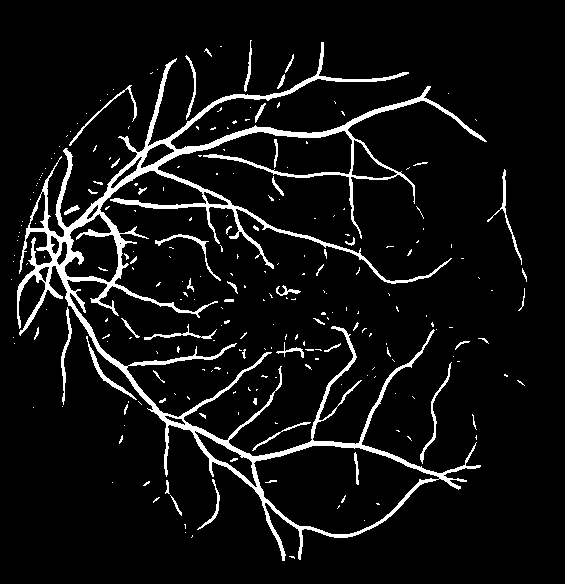

In [60]:
def vessels(img, mask, params):
    img = np.array(img.convert('YCbCr').split()[0]).astype(float)/255.

    # Ignore background
    thresh = threshold_otsu(img, nbins=255)
    black = img < thresh

    # Compute vessels
    vessels = frangi(img, scale_range=(params['scale_min'], params['scale_max']),
                     beta1=params['beta1'],
                     beta2=params['beta2'],
                     black_ridges=True)

    # Reset black pixels to black. Otherwise we get a surrounding ring.
    #vessels[mask] = 0.0
    vessels[black] = 0.0
    vessels = (vessels > params['threshold'])
    vessels = Image.fromarray(vessels*255.0)
    return vessels

idx = '21'
img_path = '../../data/raw/DRIVE/training/images/{}_training.tif'.format(idx)
gt_path = '../../data/raw/DRIVE/training/1st_manual/{}_manual1.gif'.format(idx)
mask_path = '../../data/raw/DRIVE/training/mask/{}_training_mask.gif'.format(idx)
img = Image.open(img_path)
gt = Image.open(gt_path).convert('YCbCr').split()[0]
mask = ~np.array(Image.open(mask_path).convert('YCbCr').split()[0], dtype=bool)

# Extend mask
for i in range(0,10):
    dx, dy = np.gradient(mask*1.0)
    mask = np.logical_or(mask, (dx != 0), (dy != 0)).astype(bool)

params = {'beta1': 0.7,
  'beta2': 0.01,
  'scale_max': 3,
  'scale_min': 0, 
  'threshold': 0.2}

params = {'beta1': 0.7,
    'beta2': 0.01,
    'scale_max': 3,
    'scale_min': 0,
    'threshold': 0.2}

out = vessels(img, mask=mask, params=params)
print(acc(out, gt))
out.convert('RGB')

In [61]:
from sklearn.model_selection import ParameterGrid
import random

params = {'beta1': 0.7,
    'beta2': 0.01,
    'scale_max': 3,
    'scale_min': 0,
    'threshold': 0.2}

scale_min = np.arange(0,3)
scale_max = np.arange(1,5)
beta1s = np.linspace(0.4, 0.7, num=10)
beta2s = np.linspace(0.005, 0.02, num=10)
thresholds = np.linspace(0.1, 0.4, num=10)

parameter_grid = {'scale_min': scale_min,
                  'scale_max': scale_max,
                  'beta1': beta1s,
                  'beta2': beta2s,
                  'threshold': thresholds}

# Init with past best for finetuning, like:
#parameter_grid = {k:[v] for (k,v) in params.items()} 
#parameter_grid['beta2'] = beta2s

grid = list(ParameterGrid(parameter_grid))
size_grid = len(grid)

# Explore grid in random order
# Basically a terrible combination of random and grid search
random.shuffle(grid)
print("Grid consists of {}".format(size_grid))

# Was obtained by first grid search with fixed threshold, beta1, beta2
best_acc = acc(vessels(img, mask=mask, params=params), gt)
best_param = params
for i, param in enumerate(grid):
        if i % 1000 == 0:
            print("Iteration {}".format(i))
        if param['scale_min'] >= param['scale_max']:
            continue
        v = vessels(img, mask=mask, params=param)
        cur_acc = acc(v, gt)
        if cur_acc > best_acc:
            best_acc = cur_acc
            best_param = param
            print(param, cur_acc)
best_param, best_acc

Grid consists of 12000
Iteration 0
{'beta1': 0.43333333333333335, 'beta2': 0.009999999999999998, 'scale_max': 3, 'scale_min': 0, 'threshold': 0.30000000000000004} 96.33652563947145
{'beta1': 0.5, 'beta2': 0.015, 'scale_max': 4, 'scale_min': 2, 'threshold': 0.16666666666666669} 96.33743484058674
{'beta1': 0.4666666666666667, 'beta2': 0.009999999999999998, 'scale_max': 4, 'scale_min': 0, 'threshold': 0.30000000000000004} 96.3444053824706
{'beta1': 0.6, 'beta2': 0.013333333333333332, 'scale_max': 4, 'scale_min': 0, 'threshold': 0.16666666666666669} 96.38501636562007


KeyboardInterrupt: 

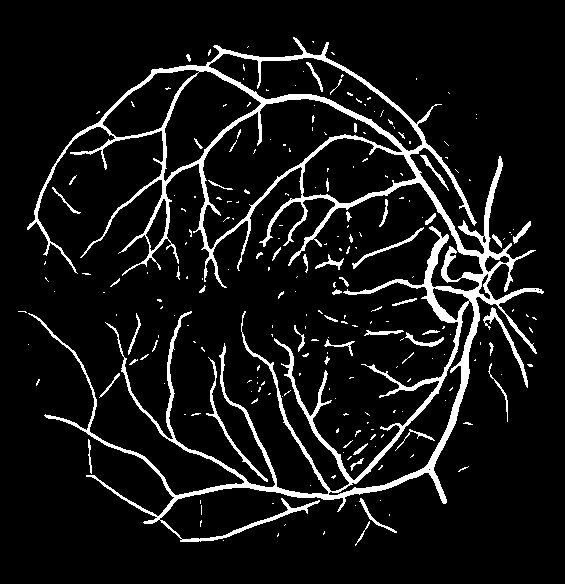

In [59]:
vessels(img, mask, best_param).convert('RGB')

In [135]:
acc(vessels(img, mask, best_param), gt)

85.0157594859983